In [34]:
import sys

from math import *;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

import numpy as np
import geom
import matplotlib.image as image
import matplotlib.pyplot as plt
import matplotlib as mpl

import MRDataAnalysis
from MRDataAnalysis import rescale as rescaleIm

import pandas
import nibabel

def vectorstr2arr(panda_vec_string,dtype=np.float):
    return np.array(list(map(float,panda_vec_string[1:-1].split())), dtype=dtype)

In [2]:
baselinedynamics=[1]
unwrap=1

In [14]:
file1="/Users/Vandiver/Data/sonalleve/HifuCav20160810/scan29_TempSag_20160810.PAR"
#file1="/Users/Vandiver/Data/Verasonics/sonalleve_20160709/Scanner/scan21_TempCor_20160709.PAR"
#file1="/Users/Vandiver/Data/Verasonics/sonalleve_20160709/Scanner/scan10_TempSag_20160709.PAR"

(tempdata1,complIm1,im1, dyntimes1)= MRDataAnalysis.read_TempScan(file1, basedynes=baselinedynamics,
            MP_interleaved=True, phase_unwrap=unwrap, pi_val=-0.3)

spc1=np.array(im1.get_header().get_zooms())

Largest number of phase-corrected voxels: 1064 [dyn 18]


In [326]:
spc1

array([ 1.729   ,  1.729   ,  3.      ,  0.024366])

In [13]:
file2="/Users/Vandiver/Data/sonalleve/HifuCav20160810/scan37_TempSag_20160810.PAR"
#file2="/Users/Vandiver/Data/Verasonics/sonalleve_20160709/Scanner/scan34_TempCor_20160709.PAR"

(tempdata2,complIm2,im2, dyntimes2)= MRDataAnalysis.read_TempScan(file2, basedynes=baselinedynamics,
            MP_interleaved=True, phase_unwrap=unwrap, pi_val=-0.3)

spc2=np.array(im2.get_header().get_zooms())

Largest number of phase-corrected voxels: 1050 [dyn 16]


In [7]:
def plotTempOverlay(tempdata, complexdata, sl=None,dyn=None, cmin=0,cmax=20, cfloor=0, graymin=0.0, graymax=1.0, ax=None,imargs={}):
    if ax is None:
        ax=plt.gca()
    
    if sl is None:
        Tdata=tempdata
        Cdata=complexdata
    else:
        Tdata=tempdata[sl]
        Cdata=complexdata[sl]
    if dyn is not None:
        Tdata=Tdata[dyn]


    magImg = rescaleIm( np.abs(Cdata) )
    greyPix = Tdata < cfloor
    rgbIm = image.cm.hot( rescaleIm(Tdata,vmin=cmin,vmax=cmax) )

    rgbIm[greyPix,3]=0
    
    imGray=ax.imshow(magImg, cmap=image.cm.gray, vmin=graymin, vmax=graymax, **imargs)
    imRGB=ax.imshow(rgbIm, **imargs)
    
    return (imGray,imRGB)

In [279]:
tempdata2.shape

(128, 128, 5, 34)

In [19]:
mrisets = [ 
    dict(use=1, path='/Users/Vandiver/Data/Verasonics/sonalleve_20160709/',
            pars='HifuScanParameters.csv', temp='scans_batch_DT_unwr_20160709.csv'),
    dict(use=1, path='/Users/Vandiver/Data/sonalleve/HifuCav20160810/',
            pars='HifuScanParams.csv', temp='scans_batch_DT_unwr_20160810.csv')]
            
tempfile='/Users/Vandiver/Data/Verasonics/cav_scans_batch_DT_unwr2.csv'

merged_frames=[]
for mi in range(len(mrisets)):
    
    if not mrisets[mi]['use']:
        continue
    
    parsfile=mrisets[mi]['path']+mrisets[mi]['pars']
    scanHifuParams = pandas.read_csv(parsfile)
            
    #tempfile=mrisets[mi]['path']+mrisets[mi]['temp']
    scanAnalysisDT = pandas.read_csv(tempfile)
    
    
    merged = scanAnalysisDT.merge(scanHifuParams)
    merged_frames.append(merged)
    
merged = pandas.concat(merged_frames)

In [20]:
merged.query("material=='pork'").query("power==40")[['file','roi']]

,file,roi
15,scan29_TempSag_20160810.PAR,[76 85 77 86 1 7]
18,scan37_TempSag_20160810.PAR,[74 83 77 86 1 7]


In [64]:
roi1 = vectorstr2arr(merged.query("file=='"+os.path.basename(file1)+"'")['roi'].iloc[0],dtype=int)
roi2 = vectorstr2arr(merged.query("file=='"+os.path.basename(file2)+"'")['roi'].iloc[0],dtype=int)

In [62]:
roi1=np.array([76,85,75,84],dtype=int)

In [67]:
roi2=np.array([76,85,74,82],dtype=int)

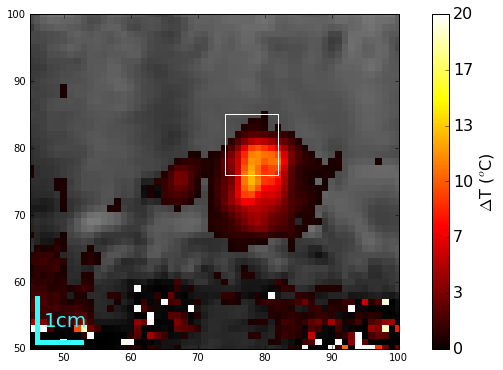

In [69]:
cmin=0
cmax=20
fig=plt.figure(figsize=(12,6))
sl=2
dyn=-5


imkeys=dict(interpolation='None')
plotTempOverlay(tempdata2[:,:,sl,dyn],complIm2[:,:,sl,dyn],imargs=imkeys,cfloor=0.5,cmax=20)
ax=plt.gca()
ax.set_xlim([45,100])
ax.set_ylim([50,100])

ax.plot( roi2[[2,2,3,3,2]],roi2[[0,1,1,0,0]], 'w')

x1cmw = 1.0/(0.1*spc[1])
y1cmw = 1.0/(0.1*spc[0])

xl1=ax.get_xlim()[0]+1
yl1=ax.get_ylim()[0]+1
ax.plot( [ xl1, xl1 + x1cmw], [ yl1, yl1 ], '-',linewidth=5.0,color=(0.2,1,1.0))
ax.plot( [ xl1-0, xl1-0], [ yl1-0, yl1-0 + y1cmw ], '-',linewidth=5.0,color=(0.2,1,1.0))
ax.text( xl1+1, yl1+y1cmw/2.0-1, "1cm", horizontalalignment='left', fontsize=20,color=(0.2,1,1.0))

#ax.set_xticks([])
#ax.set_yticks([])

tickp = np.arange(0,1.01,1/6)
tickstr = list(map(lambda s:"%0.f" % s,tickp*(cmax-cmin) + cmin))
    
#ax=fig.add_axes([0.25, 0.15, 0.5, 0.05])
sc=mpl.cm.ScalarMappable(cmap=image.cm.hot)
sc.set_array(tickp)
cb=plt.colorbar(mappable=sc,orientation='vertical',ax=ax)
cb.set_cmap(image.cm.hot)
cb.set_ticks(tickp)
cb.set_ticklabels(tickstr)  
cb.set_label('$\Delta $T ($^o$C)',fontsize=16)
cb.ax.tick_params(labelsize=16)

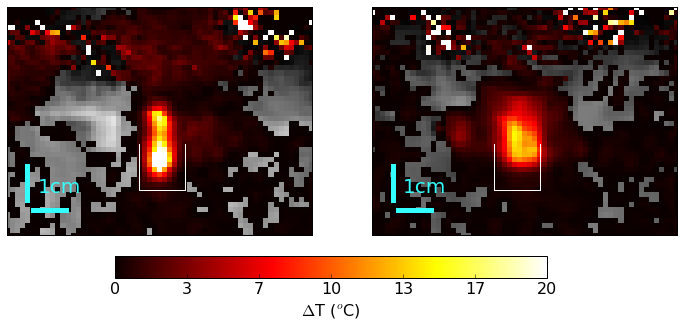

In [53]:
sl=2
dyn=-1
cfloor=-0.1
cmin=0
cmax=20
fig=plt.figure(figsize=(12,6))

imkeys=dict(interpolation='None')
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
(imGray1,imRGB1)=plotTempOverlay(tempdata1[:,:,sl,dyn],complIm1[:,:,sl,0],cmin=cmin,cmax=cmax,cfloor=cfloor,ax=ax1,imargs=imkeys )
(imGray2,imRGB2)=plotTempOverlay(tempdata2[:,:,sl,dyn],complIm2[:,:,sl,0],cmin=cmin,cmax=cmax,cfloor=cfloor,ax=ax2,imargs=imkeys )

for axi in range(2):
    ax=(ax1,ax2)[axi]
    spc=(spc1,spc2)[axi]
    
    xlim=[50,110]
    ylim=[95,50]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
    x1cmw = 1.0/(0.1*spc[1])
    y1cmw = 1.0/(0.1*spc[0])
    
    xl1=xlim[0]+5
    yl1=ylim[0]-5
    ax.plot( [ xl1, xl1 + x1cmw], [ yl1, yl1 ], linewidth=5.0,color=(0.2,1,1.0))
    ax.plot( [ xl1-1, xl1-1], [ yl1-2, yl1-2 - y1cmw ], linewidth=5.0,color=(0.2,1,1.0))
    ax.text( xl1+1, yl1-y1cmw/2.0, "1cm", horizontalalignment='left', fontsize=20,color=(0.2,1,1.0))
    
    ax.set_xticks([])
    ax.set_yticks([])
#plt.plot([0.5,0.5], [0.5, 0.9], transform=ax.transAxes)
#ax.text(0.9,0.9,'%dW'%p, transform=ax.transAxes, horizontalalignment='right', fontsize=18,color='k')

tickp = np.arange(0,1.01,1/6)
tickstr = list(map(lambda s:"%0.f" % s,tickp*(cmax-cmin) + cmin))

ax1.plot( roi1[[0,0,1,1]], roi1[[2,3,3,2]], 'w')
ax2.plot( roi2[[0,0,1,1]], roi2[[2,3,3,2]], 'w')
    
ax=fig.add_axes([0.25, 0.15, 0.5, 0.05])
sc=mpl.cm.ScalarMappable(cmap=image.cm.hot)
sc.set_array(tickp)
cb=plt.colorbar(mappable=sc,orientation='horizontal',cax=ax)
cb.set_cmap(image.cm.hot)
cb.set_ticks(tickp)
cb.set_ticklabels(tickstr)  
cb.set_label('$\Delta $T ($^o$C)',fontsize=16)
cb.ax.tick_params(labelsize=16)

In [272]:
fig.savefig("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/TempMap_Pork_40W.png")
plt.close(fig)

In [132]:
[ xlim[0]+10, xlim[0]+10 + x1cmw], [ ylim[0]+10, ylim[0]+10]

([60, 66.613756613756607], [105, 105])